In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
plt.style.use('fivethirtyeight')
%matplotlib inline 

# Load COVID-19 data

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

yesterday=datetime.date.today()-datetime.timedelta(days=1)
yesterday=yesterday.strftime("%m-%d-%Y")

daily_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'+yesterday+'.csv')

## Prepare Data

In [3]:
# Function to unpivot the data and cleanup fr common datasets
def melt_df(df):
    df = pd.melt(df, id_vars=["Country/Region","Province/State","Lat","Long"],var_name='Date', value_name="Confirmed")
    df = df.rename(columns={"Country/Region":"Country","Province/State":"State"}).drop(columns=["State"])
    #df["Date"] = pd.to_datetime(df["Date"])
    df = df.astype({"Country":np.str,"Date":np.datetime64})
    # Lat and Long are same for a country irrespective of state/province. reset_index() used to repeate the group names
    # Instead of reset_index as_index=False in groupby does the same
    # df.groupby(["Country","Date","Lat","Long"], as_index=False)[["Confirmed"]].sum()
    # However asindex removes column from final DF. reset_index keeps it.
    df = df.groupby(["Country","Date","Lat","Long"])[["Confirmed"]].sum().reset_index()
    return df
    
total_confirmed_df = melt_df(confirmed_df)
total_deaths_df = melt_df(deaths_df)
total_recoveries_df = melt_df(recoveries_df)
#print(total_confirmed_df["Country"].unique())
#print(total_confirmed_df[total_confirmed_df["Country"]=="US"])

# daily data seems to be present in total dataset. Skipping the processing of daily_data for now
#print(total_confirmed_df[total_confirmed_df["Date"]==yesterday])
#print(daily_data[["Country_Region","Lat","Long_","Confirmed","Deaths","Recovered","Active"]].sort_values(by=["Country_Region"]))


## Generate list of forecast dates for next 15 days

In [4]:
def is_date(date_text):
    try:
        datetime.datetime.strptime(date_text, "%m/%d/%y")
        return True
    except ValueError:
        return False

dates = list(confirmed_df.keys())

# Collect all dates. Get rid of headers
dates = [datetime.datetime.strptime(d, "%m/%d/%y").strftime("%m-%d-%Y") for d in dates if is_date(d)]

#dates = pd.DataFrame(confirmed_df.keys(),columns=["Date"],dtype=np.datetime64)
#dates = pd.to_datetime(dates, errors="coerce")

latest_date = pd.to_datetime(dates, errors="coerce").max()
forecast_days = 15
forecast_end_date = latest_date + datetime.timedelta(days=forecast_days)

forecast_dates=[]
dt=latest_date+ datetime.timedelta(days=1)

while dt <= forecast_end_date:
    forecast_dates.append(dt.strftime('%m-%d-%Y'))
    dt += datetime.timedelta(days=1)

# Create an array of numbers for each day
days_arr = np.array([i for i in range(len(dates))]).reshape(-1, 1)
# Create an array of numbers for each day including forecast period
forecast_days_arr = np.array([i for i in range(len(dates)+len(forecast_dates))]).reshape(-1, 1)

## Split data for traning and testing

In [5]:
confirmed_cases = np.array(total_confirmed_df.groupby("Date")["Confirmed"].sum().reset_index()["Confirmed"]).reshape(-1,1)

# Split the data between training and testing
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_arr, confirmed_cases, test_size=0.10, shuffle=False)

## Forecasting: Support Vector Machine

In [6]:
# Using Support Vector Regressor
# gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
# epsilon: It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
# degree: Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=7, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(forecast_days_arr)

c:\python\python37\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 82436.59467095835
MSE: 12147547521.097616


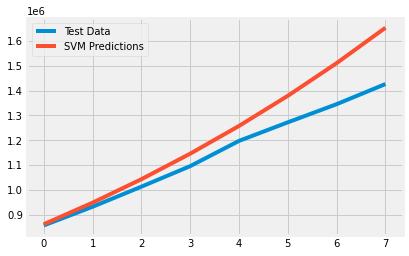

In [7]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

## Polynomial Regression

In [8]:
poly = PolynomialFeatures(degree=9)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_forcast = poly.fit_transform(forecast_days_arr)

In [9]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 267223.8130916953
MSE: 134606771898.81918


In [10]:
print(linear_model.coef_)

[[ 3.51187982e+01  1.63626891e+02  3.81483369e+02 -8.45900004e+01
   9.91230723e+00 -5.64257083e-01  1.72312316e-02 -2.91631493e-04
   2.58595370e-06 -9.36447009e-09]]


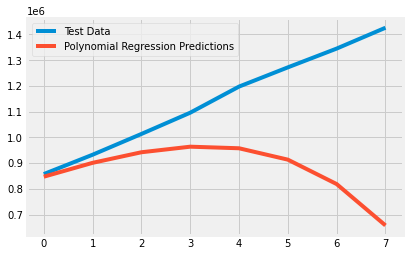

In [11]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

## Bayesian Ridge Regression

In [12]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.3s finished
c:\python\python37\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [13]:
bayesian_search.best_params_

{'tol': 0.0001,
 'lambda_2': 1e-07,
 'lambda_1': 1e-05,
 'alpha_2': 1e-07,
 'alpha_1': 1e-05}

In [14]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 348709.29659678787
MSE: 203303911868.78653


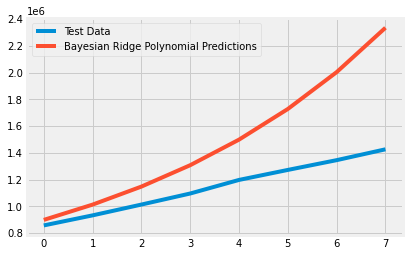

In [15]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

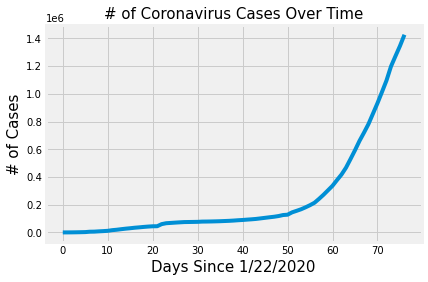

In [16]:
plt.plot(days_arr, confirmed_cases)
plt.title('# of Coronavirus Cases Over Time', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

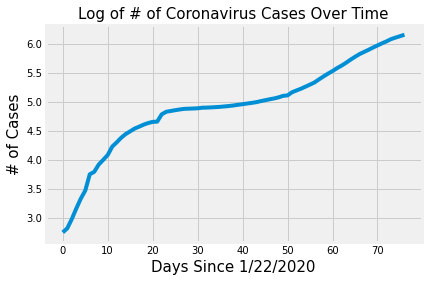

In [17]:
plt.plot(days_arr, np.log10(confirmed_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

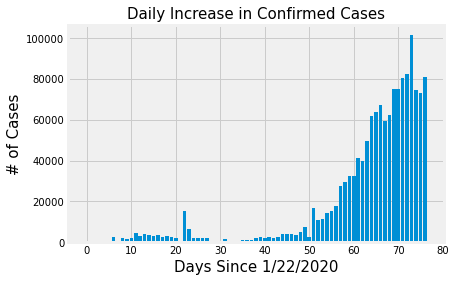

In [18]:
daily_increase = confirmed_cases.flatten().tolist()
# Calculate the difference between current and prior element
# daily_increase=[y-x for x, y in zip(daily_increase[0::], daily_increase[1::])]

daily_increase=np.diff(daily_increase).tolist() # difference using numpy

# to match the shape
daily_increase.insert(0,0)

#np ndarray to list
plt.bar(days_arr.flatten().tolist(), daily_increase)
plt.title('Daily Increase in Confirmed Cases', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

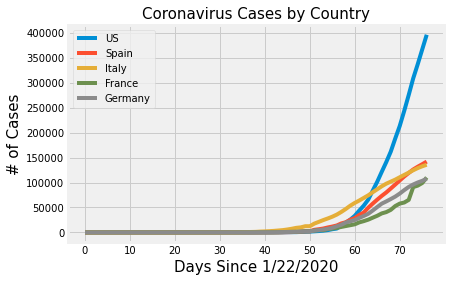

In [19]:
cases_by_country = total_confirmed_df.groupby(["Country","Date"])["Confirmed"].sum().reset_index()
#np.array(total_confirmed_df[total_confirmed_df["Country"]==country].groupby("Date")["Confirmed"].sum().reset_index()["Confirmed"]).reshape(-1,1).flatten().tolist()

# Top 5 countries
# top_n_countries = total_confirmed_df[total_confirmed_df["Date"]==yesterday].groupby(by="Country", as_index=False)[["Country","Confirmed"]].sum().sort_values(by="Confirmed", ascending=False, axis=0)
#top_n_countries = top_n_countries.nlargest(10, "Confirmed")["Country"]

top_n_countries = cases_by_country[cases_by_country["Date"]==yesterday].sort_values(by="Confirmed", ascending=False, axis=0).nlargest(5, "Confirmed")["Country"]

def get_cases_by_country(country):    
    return np.array(cases_by_country[cases_by_country["Country"]==country][["Confirmed"]]).reshape(-1,1).flatten().tolist()

for country in top_n_countries:
    plt.plot(days_arr, get_cases_by_country(country))
plt.title('Coronavirus Cases by Country', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(top_n_countries, prop={'size': 10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

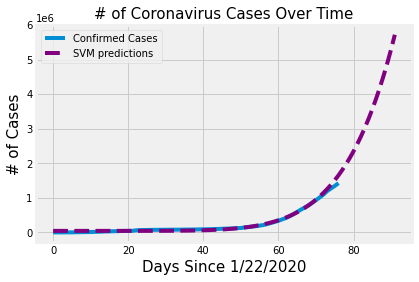

In [20]:
plt.plot(days_arr, confirmed_cases)
plt.plot(forecast_days_arr, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

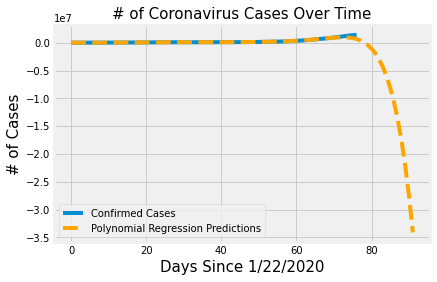

In [21]:
plt.plot(days_arr, confirmed_cases)
plt.plot(forecast_days_arr, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

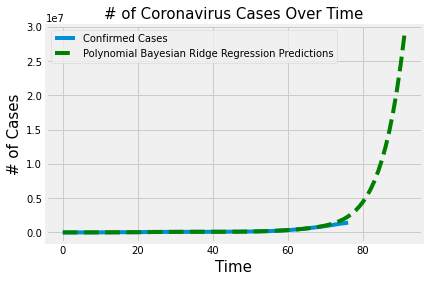

In [22]:
plt.plot(days_arr, confirmed_cases)
plt.plot(forecast_days_arr, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=15)
plt.xlabel('Time', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [23]:
# Future predictions using SVM 
print('SVM Forecast cases:')
set(zip(forecast_dates[-10:], np.round(svm_pred[-10:])))

SVM Forecast cases:


{('04-13-2020', 2781187.0),
 ('04-14-2020', 3023484.0),
 ('04-15-2020', 3283943.0),
 ('04-16-2020', 3563687.0),
 ('04-17-2020', 3863889.0),
 ('04-18-2020', 4185783.0),
 ('04-19-2020', 4530659.0),
 ('04-20-2020', 4899868.0),
 ('04-21-2020', 5294824.0),
 ('04-22-2020', 5717008.0)}

In [24]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(forecast_dates[-10:], np.round(linear_pred[-10:])))

Polynomial regression future predictions:


{('04-13-2020', -2985222.0),
 ('04-14-2020', -4350723.0),
 ('04-15-2020', -6056910.0),
 ('04-16-2020', -8166707.0),
 ('04-17-2020', -10752064.0),
 ('04-18-2020', -13894954.0),
 ('04-19-2020', -17688458.0),
 ('04-20-2020', -22237944.0),
 ('04-21-2020', -27662331.0),
 ('04-22-2020', -34095454.0)}

In [25]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(forecast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('04-13-2020', 6318318.0),
 ('04-14-2020', 7505128.0),
 ('04-15-2020', 8915532.0),
 ('04-16-2020', 10586570.0),
 ('04-17-2020', 12560293.0),
 ('04-18-2020', 14884294.0),
 ('04-19-2020', 17612280.0),
 ('04-20-2020', 20804686.0),
 ('04-21-2020', 24529342.0),
 ('04-22-2020', 28862179.0)}

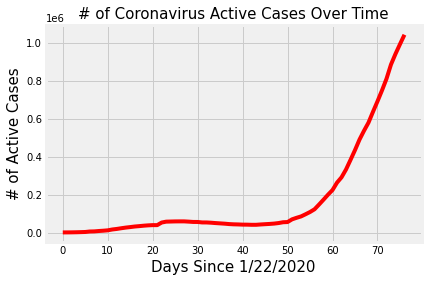

In [26]:
active_cases_df=total_confirmed_df.groupby(by="Date")["Confirmed"].sum()-total_deaths_df.groupby(by="Date")["Confirmed"].sum()-total_recoveries_df.groupby(by="Date")["Confirmed"].sum()

plt.plot(days_arr, active_cases_df, color='red')
plt.title('# of Coronavirus Active Cases Over Time', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Active Cases', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()


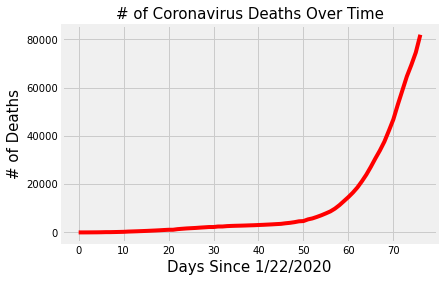

In [27]:
#plt.figure(figsize=(16, 9))
plt.plot(days_arr, total_deaths_df.groupby(by="Date")["Confirmed"].sum(), color='red')
plt.title('# of Coronavirus Deaths Over Time', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Deaths', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

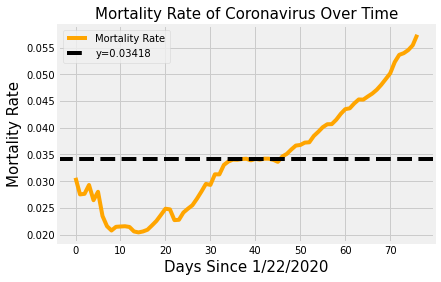

In [28]:
mortality_rate_df = total_deaths_df.groupby(by="Date")["Confirmed"].sum()/total_confirmed_df.groupby(by="Date")["Confirmed"].sum()

mean_mortality_rate = np.mean(mortality_rate_df)
#plt.figure(figsize=(16, 9))
plt.plot(days_arr, mortality_rate_df, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=15)
plt.legend(['Mortality Rate', 'y='+str(mean_mortality_rate.round(5))], prop={'size': 10})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('Mortality Rate', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

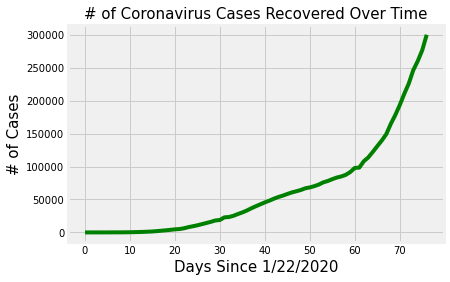

In [29]:
#plt.figure(figsize=(16, 9))
plt.plot(days_arr, total_recoveries_df.groupby(by="Date")["Confirmed"].sum(), color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

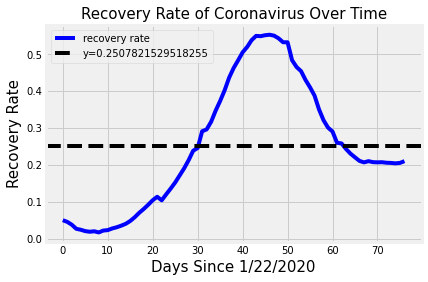

In [30]:
recovery_rate = total_recoveries_df.groupby(by="Date")["Confirmed"].sum()/total_confirmed_df.groupby(by="Date")["Confirmed"].sum()

mean_recovery_rate = np.mean(recovery_rate)
#plt.figure(figsize=(12, 5))
plt.plot(days_arr, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=15)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 10})
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('Recovery Rate', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

Graphing deaths against recoveries

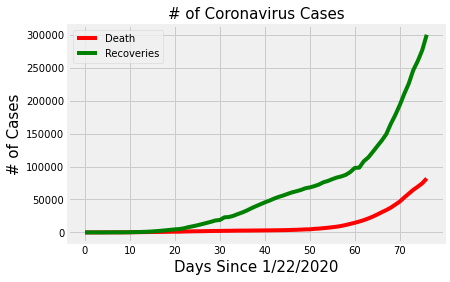

In [31]:
plt.plot(days_arr, total_deaths_df.groupby(by="Date")["Confirmed"].sum(), color='r')
plt.plot(days_arr, total_recoveries_df.groupby(by="Date")["Confirmed"].sum(), color='green')
plt.legend(['Death', 'Recoveries'], loc='best', fontsize=10)
plt.title('# of Coronavirus Cases', size=15)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

Plotting the number of deaths against the number of recoveries

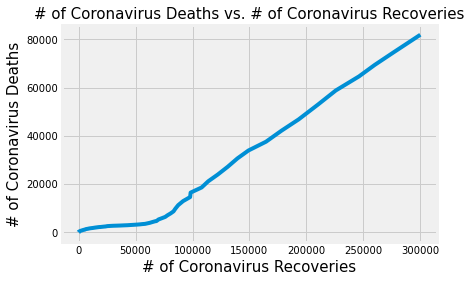

In [32]:
plt.plot(total_recoveries_df.groupby(by="Date")["Confirmed"].sum(), total_deaths_df.groupby(by="Date")["Confirmed"].sum())
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=15)
plt.xlabel('# of Coronavirus Recoveries', size=15)
plt.ylabel('# of Coronavirus Deaths', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

Getting information about countries/regions that have confirmed coronavirus cases

In [33]:
# Current Top 50 countries by confirmed cases
#country_list_df=daily_data.groupby(["Country_Region"])["Confirmed"].sum().reset_index()
#country_list_df=country_list_df.sort_values(by="Confirmed", ascending=False, axis=0)["Country_Region"]
daily_cases_df=daily_data.groupby(by="Country_Region").sum()[['Confirmed', 'Deaths', 'Recovered', 'Active']].reset_index()
daily_cases_df=daily_cases_df.sort_values(by="Confirmed", ascending=False)
daily_cases_top50_df = daily_cases_df.nlargest(50, columns="Confirmed")

cases_by_country_df = pd.DataFrame({ 'Country': daily_cases_top50_df["Country_Region"],
                            'Confirmed': daily_cases_top50_df["Confirmed"],
                            'Deaths': daily_cases_top50_df["Deaths"],
                            'Recoveries' : daily_cases_top50_df["Recovered"],
                            'Active' : daily_cases_top50_df["Active"],
                            'Mortality Rate': daily_cases_top50_df["Deaths"]/daily_cases_top50_df["Confirmed"]})

cases_by_country_df.style.background_gradient(cmap='rainbow').format({'Confirmed': '{:,}', 'Deaths': '{:,}', 'Recoveries': '{:,}', 'Active': '{:,}', 'Mortality Rate': "{:.2%}"}).hide_index()

Country,Confirmed,Deaths,Recoveries,Active,Mortality Rate
US,"396,223","12,722","21,763",0,3.21%
Spain,"141,942","14,045","43,208","84,689",9.89%
Italy,"135,586","17,127","24,392","94,067",12.63%
France,"110,065","10,343","19,523","80,199",9.40%
Germany,"107,663","2,016","36,081","69,566",1.87%
China,"82,718","3,335","77,410","1,973",4.03%
Iran,"62,589","3,872","27,039","31,678",6.19%
United Kingdom,"55,949","6,171",325,"49,453",11.03%
Turkey,"34,109",725,"1,582","31,802",2.13%
Switzerland,"22,253",821,"8,704","12,728",3.69%


In [34]:
#daily_data[daily_data["Country_Region"]=="US"]
#total_recoveries_df[(total_recoveries_df["Country"]=="US") & (total_recoveries_df["Date"]==yesterday)]

total_US_cases_df = daily_data[(daily_data["Country_Region"]=="US")]
total_US_cases_df = total_US_cases_df.rename(columns={"Province_State":"State","Long_":"Long"})
total_US_cases_df = total_US_cases_df.groupby(["State"])[["Confirmed","Deaths","Recovered","Active"]].sum().reset_index()
total_US_cases_df=total_US_cases_df.sort_values(by="Confirmed", ascending=False)
daily_US_cases_top25_df = total_US_cases_df.nlargest(25, columns="Confirmed")

# Note: Recoveries and Active data is missing
US_cases_by_state_df = daily_US_cases_top25_df = pd.DataFrame({ 'US State': daily_US_cases_top25_df["State"],
                            'Confirmed': daily_US_cases_top25_df["Confirmed"],
                            'Deaths': daily_US_cases_top25_df["Deaths"],
                            'Recoveries' : daily_US_cases_top25_df["Recovered"],
                            'Active' : daily_US_cases_top25_df["Active"],
                            'Mortality Rate': daily_US_cases_top25_df["Deaths"]/daily_US_cases_top25_df["Confirmed"]})
US_cases_by_state_df.style.background_gradient(cmap='viridis').format({'Confirmed': '{:,}', 'Deaths': '{:,}', 'Recoveries': '{:,}', 'Active': '{:,}', 'Mortality Rate': "{:.2%}"}).hide_index()

US State,Confirmed,Deaths,Recoveries,Active,Mortality Rate
New York,"139,875","5,489",0,0,3.92%
New Jersey,"44,416","1,232",0,0,2.77%
Michigan,"18,970",845,0,0,4.45%
California,"17,351",432,0,0,2.49%
Louisiana,"16,284",582,0,0,3.57%
Massachusetts,"15,202",356,0,0,2.34%
Pennsylvania,"14,853",247,0,0,1.66%
Florida,"14,545",283,0,0,1.95%
Illinois,"12,271",308,0,0,2.51%
Texas,"8,925",160,0,0,1.79%


***Visual Representations*** (bar charts and pie charts)

No handles with labels found to put in legend.


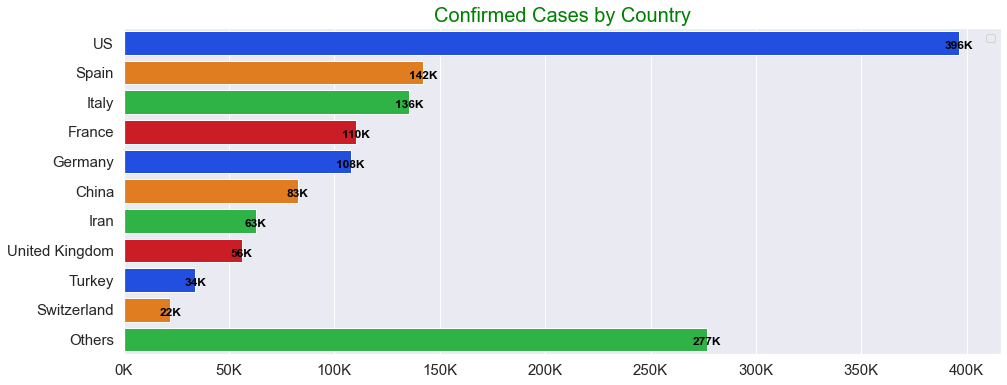

In [35]:
import seaborn as sns

# Get top 10 countries and select Country and Confirmed columns
top_10_countries_df=daily_cases_df.iloc[:10,[0,1]]
# Explicit index is adeed to avoid ValueError: If using all scalar values, you must pass an index
other_countries_df=pd.DataFrame({"Country_Region":"Others", "Confirmed":daily_cases_df.iloc[10:,1].sum()}, index=[0])
top_10_countries_df=top_10_countries_df.append(other_countries_df)

def format_number(n):
    if n<1000000:
        return '{:,.0f}'.format(n/1000) + 'K'
    else:
        return '{:,.0f}'.format(n/1000000) + 'M'

# defaults                                                                                                         
sns.set()
f, ax = plt.subplots(figsize=(14, 6))
palette = sns.color_palette("bright", 4)
g=sns.barplot(data=top_10_countries_df, x="Confirmed", y="Country_Region", palette= palette)
g.set_title("Confirmed Cases by Country", size=20, Color="green")
g.legend(bbox_to_anchor=(1, 1), ncol=1)
#xlabels = ['{:,.2f}'.format(x/1000) + 'K' if x<1000000 else '{:,.0f}'.format(x/1000000) + 'M' for x in g.get_xticks()]
xlabels = [format_number(x) for x in ax.get_xticks()]
g.set_xticklabels(xlabels, size=15)
g.set_yticklabels(ax.get_yticklabels(), size=15)
ax.set_ylabel('')    
ax.set_xlabel('')
# Show bar values on the bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width, p.get_y()+p.get_height()/2. + 0.2, format_number(width), ha="center", size=12, color="black",weight='bold')
plt.show()
#sns.axes_style()

No handles with labels found to put in legend.


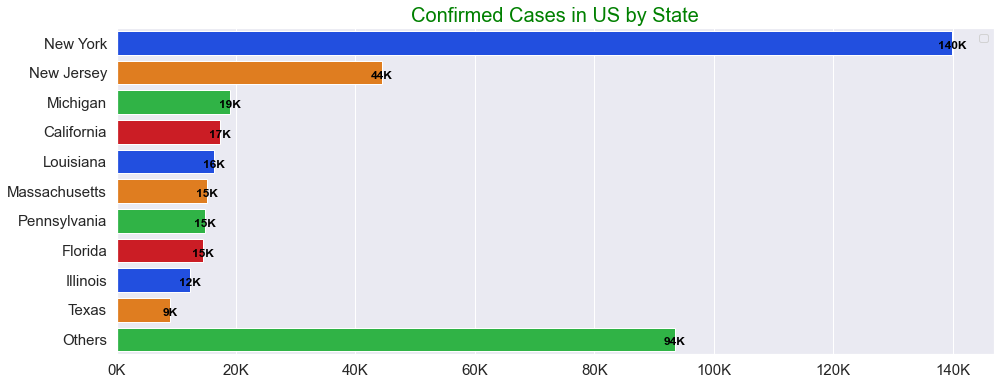

In [36]:
import seaborn as sns

total_US_cases_df = daily_data[(daily_data["Country_Region"]=="US")]
total_US_cases_df = total_US_cases_df.rename(columns={"Province_State":"State","Long_":"Long"})
total_US_cases_df = total_US_cases_df.groupby(["State"])[["Confirmed"]].sum().reset_index()
total_US_cases_df= total_US_cases_df.sort_values(by="Confirmed", ascending=False)
daily_US_cases_top10_df = total_US_cases_df.nlargest(10, columns="Confirmed")

other_US_states_df=pd.DataFrame({"State":"Others", "Confirmed":total_US_cases_df.iloc[10:,1].sum()}, index=[0])
daily_US_cases_top10_df=daily_US_cases_top10_df.append(other_US_states_df)

# defaults                                                                                                         
sns.set()
f, ax = plt.subplots(figsize=(14, 6))
palette = sns.color_palette("bright", 4)
g=sns.barplot(data=daily_US_cases_top10_df, x="Confirmed", y="State", palette= palette)
g.set_title("Confirmed Cases in US by State", size=20, Color="green")
g.legend(bbox_to_anchor=(1, 1), ncol=1)
xlabels = [format_number(x) for x in ax.get_xticks()]
g.set_xticklabels(xlabels, size=15)
g.set_yticklabels(ax.get_yticklabels(), size=15)
ax.set_ylabel('')    
ax.set_xlabel('')
# Show bar values on the bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width, p.get_y()+p.get_height()/2. + 0.2, format_number(width), ha="center", size=12, color="black",weight='bold')
plt.show()
#sns.axes_style()

In [37]:
#sns.palplot(sns.hls_palette(10, l=.4, s=.8))
#sns.palplot(sns.color_palette("hls", 10))
#sns.palplot(sns.dark_palette("purple"))
#sns.palplot(sns.diverging_palette(0, 255, sep=8, s=75, l=40, n=10, center="dark"))
#sns.palplot(sns.dark_palette(color="red", n_colors=10, reverse=True))

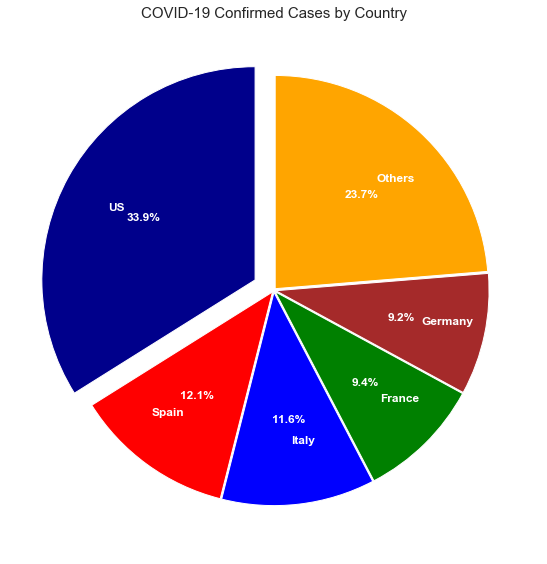

In [38]:
# Get top 10 countries and select Country and Confirmed columns
top_5_countries_df=daily_cases_df.iloc[:5,[0,1]]
# Explicit index is adeed to avoid ValueError: If using all scalar values, you must pass an index
other_countries_df=pd.DataFrame({"Country_Region":"Others", "Confirmed":daily_cases_df.iloc[10:,1].sum()}, index=[0])
top_5_countries_df=top_5_countries_df.append(other_countries_df)


#colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(top_5_countries_df["Country_Region"].unique()))
colors = ['darkblue', 'red', 'blue', 'green', 'brown', 'orange']
plt.figure(figsize=(8,8))
plt.title('COVID-19 Confirmed Cases by Country', size=15)
explode=(0.1, 0.01, 0.01, 0.01, 0.01, 0.01)
textprops={'fontsize': 12, 'weight':'bold', 'color':'white'}
labels=top_5_countries_df["Country_Region"].unique()

patches, texts, autotexts = plt.pie(top_5_countries_df["Confirmed"], colors=colors,explode=explode,autopct='%1.1f%%',shadow=False,startangle=90,labels=labels,labeldistance=0.7, textprops=textprops)
#[ _.set_fontsize(15) for _ in texts] #texts[0].set_fontsize(4)
#plt.legend(top_5_countries_df["Country_Region"].unique(), loc='best', fontsize=15)
plt.tight_layout()
plt.show()

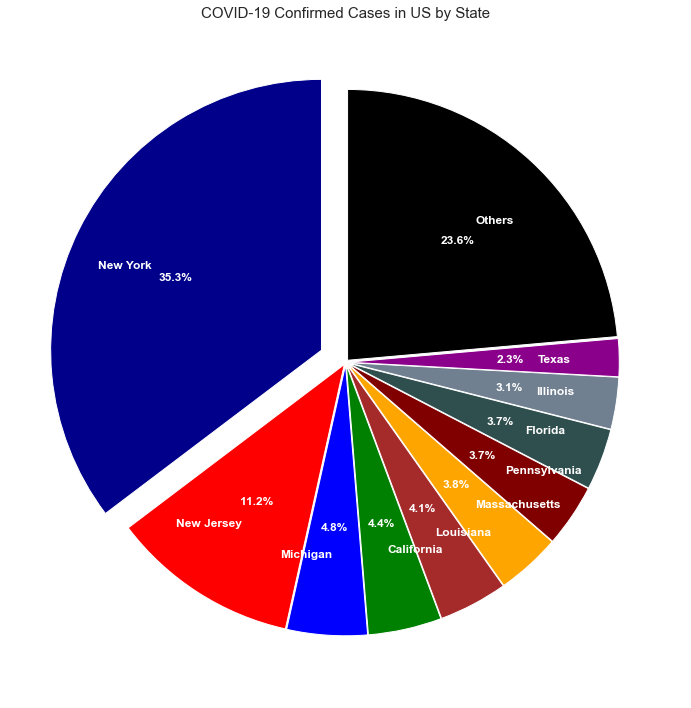

In [39]:
total_US_cases_df = daily_data[(daily_data["Country_Region"]=="US")]
total_US_cases_df = total_US_cases_df.rename(columns={"Province_State":"State","Long_":"Long"})
total_US_cases_df = total_US_cases_df.groupby(["State"])[["Confirmed"]].sum().reset_index()
total_US_cases_df= total_US_cases_df.sort_values(by="Confirmed", ascending=False)
daily_US_cases_top10_df = total_US_cases_df.nlargest(10, columns="Confirmed")

other_US_states_df=pd.DataFrame({"State":"Others", "Confirmed":total_US_cases_df.iloc[10:,1].sum()}, index=[0])
daily_US_cases_top10_df=daily_US_cases_top10_df.append(other_US_states_df)

colors = ['darkblue', 'red', 'blue', 'green', 'brown', 'orange','maroon','darkslategrey','slategrey','darkmagenta','black']
plt.figure(figsize=(10,10))
plt.title('COVID-19 Confirmed Cases in US by State', size=15)
explode=(0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
textprops={'fontsize': 12, 'weight':'bold', 'color':'white'}
labels=daily_US_cases_top10_df["State"].unique()

patches, texts, autotexts = plt.pie(daily_US_cases_top10_df["Confirmed"], colors=colors,explode=explode,autopct='%1.1f%%',shadow=False,startangle=90,labels=labels,labeldistance=0.7, textprops=textprops)
plt.tight_layout()
plt.show()